# Adagrad --- 从0开始


在我们之前的优化算法中，无论是梯度下降、随机梯度下降、小批量随机梯度下降还是使用动量法，模型参数中的每一个元素在相同时刻都使用同一个学习率来自我迭代。

举个例子，当一个模型的损失函数为$L$，参数为一个多维向量$[x_1, x_2]^\top$时，该向量中每一个元素在更新时都使用相同的学习率，例如在学习率为$\eta$的梯度下降中：

$$
x_1 := x_1 - \eta \frac{\partial{L}}{\partial{x_1}} \\
x_2 := x_2 - \eta \frac{\partial{L}}{\partial{x_2}}
$$

其中元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代。如果让$x_1$和$x_2$使用不同的学习率自我迭代呢？


Adagrad就是一个在迭代过程中不断自我调整学习率，并让模型参数中每个元素都使用不同学习率的优化算法。


## Adagrad算法

由于小批量随机梯度下降包含了梯度下降和随机梯度下降这两种特殊形式，我们在之后的优化章节里提到的梯度都指的是小批量随机梯度。由于我们会经常用到按元素操作，这里稍作介绍。假设$\mathbf{x} = [4, 9]^\top$，以下是一些按元素操作的例子：

* 按元素相加： $\mathbf{x} + 1 = [5, 10]^\top$
* 按元素相乘： $\mathbf{x} \odot \mathbf{x} = [16, 81]^\top$
* 按元素相除： $72 / \mathbf{x} = [18, 8]^\top$
* 按元素开方： $\sqrt{\mathbf{x}} = [2, 3]^\top$

Adagrad的算法会使用一个梯度按元素平方的累加变量$\mathbf{s}$，并将其中每个元素初始化为0。在每次迭代中，首先计算[小批量梯度](gd-sgd-scratch.md) $\mathbf{g}$，然后将该梯度按元素平方后累加到变量$\mathbf{s}$：

$$\mathbf{s} := \mathbf{s} + \mathbf{g} \odot \mathbf{g} $$

然后我们将模型参数中每个元素的学习率通过按元素操作重新调整一下：

$$\mathbf{g}^\prime := \frac{\eta}{\sqrt{\mathbf{s} + \epsilon}} \odot \mathbf{g} $$

其中$\eta$是初始学习率，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-7}$。请注意其中按元素开方、除法和乘法的操作。这些按元素操作使得模型参数中每个元素都分别拥有自己的学习率。

需要强调的是，由于梯度按元素平方的累加变量$\mathbf{s}$出现在分母，Adagrad的核心思想是：如果模型损失函数有关一个参数元素的偏导数一直都较大，那么就让它的学习率下降快一点；反之，如果模型损失函数有关一个参数元素的偏导数一直都较小，那么就让它的学习率下降慢一点。然而，由于$\mathbf{s}$一直在累加按元素平方的梯度，每个元素的学习率在迭代过程中一直在降低或不变。所以在有些问题下，当学习率在迭代早期降得较快时且当前解依然不理想时，Adagrad在迭代后期可能较难找到一个有用的解。

最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

$$\mathbf{x} := \mathbf{x} - \mathbf{g}^\prime $$




## Adagrad的实现

Adagrad的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
# Adagrad算法
def adagrad(params, sqrs, lr, batch_size):
    eps_stable = 1e-7
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] += nd.square(g)
        div = lr * g / nd.sqrt(sqr + eps_stable)
        param[:] -= div

## 实验

实验中，我们以线性回归为例。其中真实参数`w`为[2, -3.4]，`b`为4.2。我们把梯度按元素平方的累加变量初始化为和参数形状相同的零张量。

In [2]:
from mxnet import ndarray as nd
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把梯度按元素平方的累加变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
    return params, sqrs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

接下来定义训练函数。训练函数的period参数说明，每次采样过该数目的数据点后，记录当前目标函数值用于作图。例如，当period和batch_size都为10时，每次迭代后均会记录目标函数值。

另外，与随机梯度下降算法不同，这里的初始学习率`lr`没有自我衰减。

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            adagrad([w, b], sqrs, lr, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" % 
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

使用Adagrad，最终学到的参数值与真实值较接近。

Batch size 10, Learning rate 0.900000, Epoch 1, loss 5.3753e-05


Batch size 10, Learning rate 0.900000, Epoch 2, loss 4.9244e-05


Batch size 10, Learning rate 0.900000, Epoch 3, loss 4.9044e-05
w: [[ 2.00095844 -3.3999505 ]] b: 4.19947 



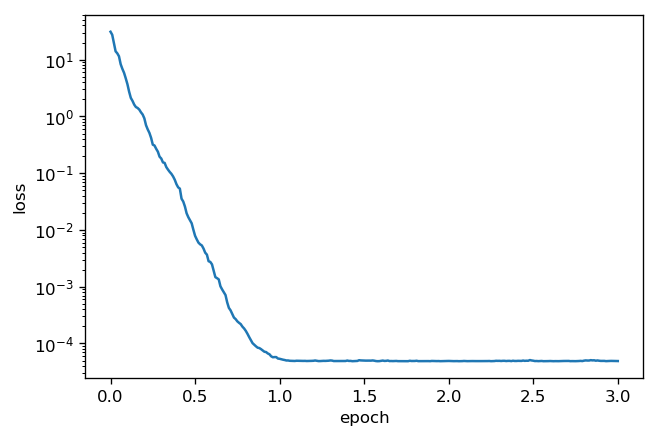

In [4]:
train(batch_size=10, lr=0.9, epochs=3, period=10)

## 结论

* Adagrad是一个在迭代过程中不断自我调整学习率，并让模型参数中每个元素都使用不同学习率的优化算法。


## 练习

* 我们提到了Adagrad可能的问题在于按元素平方的梯度累加变量。你能想到什么办法来应对这个问题吗？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2273)